In [1]:
import pandas as pd
from tools import *
from CONSTANT import *
import os

from tqdm import tqdm

import matplotlib.pyplot as plt

pd.set_option("display.max_info_columns", 1300)

import gc

%matplotlib inline

# HKU956

# threshold determining

In [35]:
av_rating = pd.read_csv(r'./HKU956/3. AV_ratings_duration.csv')
av_rating['valence'] = av_rating['valence'].apply(lambda x: 1 if x == 'positive' else 0)
av_rating['arousal'] = av_rating['arousal'].apply(lambda x: 1 if x == 'positive' else 0)
del av_rating['play_duration']
av_rating.head()

,participant_id,song_no,song_id,valence_rating,valence,arousal_rating,arousal
0,hku1919,16,370177,9.3,1,1.0,1
1,hku1919,8,1119687,9.8,1,-3.0,0
2,hku1919,18,77933,-0.1,0,1.9,1
3,hku1919,14,238585,1.0,1,-1.8,0
4,hku1919,20,1168711,0.2,1,-3.4,0


In [34]:
# av_rating[av_rating['valence_rating']==' ']

,participant_id,song_no,song_id,valence_rating,valence,arousal_rating,arousal
239,hku1929,7,1119024,,1,6.0,1


In [37]:
# minmax_scale(av_rating['valence_rating'])

In [3]:
from sklearn.cluster import KMeans

## clutering before minmax

array([2.11724875, 1.1193303 ])

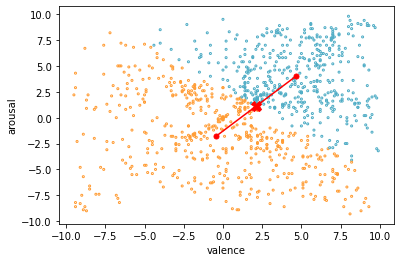

In [128]:
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

kmeans = KMeans(n_clusters=2, random_state=0).fit(av_rating[['valence_rating', 'arousal_rating']])
plt.scatter(y=av_rating['arousal_rating'], x=av_rating['valence_rating'], 
            facecolors='none', edgecolors=['#4EACC5' if i==0 else '#FF9C34' for i in kmeans.labels_ ], s=4)
plt.ylabel('arousal')
plt.xlabel('valence')
plt.plot(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1], c='red', marker="o", markersize=5)
threshold = kmeans.cluster_centers_.sum(axis=0)/2
plt.plot(threshold[0], threshold[1], c='red', marker="X", markersize=10)
kmeans.cluster_centers_.sum(axis=0)/2

In [133]:
midpoint = kmeans.cluster_centers_.sum(axis=0)/2
av_rating['valence_label'] = av_rating['valence_rating'].apply(lambda x: 1 if x>midpoint[0] else 0)
av_rating['arousal_label'] = av_rating['arousal_rating'].apply(lambda x: 1 if x>midpoint[1] else 0)
av_rating.head()

,participant_id,song_no,song_id,valence_rating,valence,arousal_rating,arousal,valence_label,arousal_label
0,hku1919,16,370177,9.3,1,1.0,1,1,0
1,hku1919,8,1119687,9.8,1,-3.0,0,1,0
2,hku1919,18,77933,-0.1,0,1.9,1,0,1
3,hku1919,14,238585,1.0,1,-1.8,0,0,0
4,hku1919,20,1168711,0.2,1,-3.4,0,0,0


In [134]:
av_rating['valence_label'].value_counts()

1    489
0    467
Name: valence_label, dtype: int64

In [135]:
av_rating['arousal_label'].value_counts()

1    502
0    454
Name: arousal_label, dtype: int64

# signal processing

In [136]:
def signal_processer(user, signal_name, signal_files, win_size=4, step=2):
    all_signals = {}
    tmp_signals = []
    va_info_col = ['participant_id', 'song_no', 'song_id', 'valence_rating',
                   'valence', 'arousal_rating', 'arousal', 'play_duration']
    for file in signal_files:
        try:
            filename = os.path.split(file)[-1]
            filename, file_extension = os.path.splitext(filename)
            if file_extension != '.csv':
                continue
            # songno, songid = filename.split('_')
            
            signal = pd.read_csv(file, header=None).iloc[:,0].values

            # bandpass or lowpass filtering & resampling
            if signal_name == 'EDA':
                signal = butter_lowpass_filter(signal, cutOff=CUTOFF['EDA'], fs=SAMPLERATE['EDA'])
                signal = resample_by_interpolation(signal, input_fs=SAMPLERATE['EDA'], output_fs=100)
            elif signal_name in ['TEMP', 'BVP']:
                signal = butter_bandpass_filter(signal, lowcut=CUTOFF[signal_name][0], highcut=CUTOFF[signal_name][1], fs=SAMPLERATE[signal_name])
                signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=100)
            elif signal_name == 'HR':
                # signal = chauvenet_filter(signal)
                # print(signal)
                signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=100)
            else: # IBI
                continue

            tmp_signals.extend(signal.tolist())
            all_signals[filename] = signal
            
        except Exception as e:
            print(e, file)
            raise e
        
    signal_max = np.max(tmp_signals)
    signal_min = np.min(tmp_signals)

    del tmp_signals

    signal_df = []

    # normalization, segmentation, $ concatenation
    for filename, signal in all_signals.items():
        song_no, song_id = filename.split('_')
        signal = (signal - signal_min) / (signal_max - signal_min)
        signal = pd.Series(signal).interpolate().tolist()
        
        segments = np.array(segment_generator(signal, win_size=win_size*100, step=step*100)[1:])
        seg_cols = ['{}_seg{}'.format(signal_name, i) for i in range(segments.shape[1])]
        segment_df = pd.DataFrame(columns=seg_cols, data=segments)

        segment_df['segment_id'] = segment_df.index.tolist()
        segment_df['song_no'] = int(song_no)
        segment_df['song_id'] = int(song_id)
        segment_df['participant_id'] = user

        # va_info = [av_rating[(av_rating['participant_id']==user) & (av_rating['song_no']==int(songno)) & (av_rating['song_id']==int(songid))].values.tolist()[0] for _ in range(len(segments))]
        # tmp_va_info = pd.DataFrame(columns=va_info_col, data=va_info)
        # segment_df = pd.concat([tmp_va_info, segment_df], axis=1)
        
        signal_df.append(segment_df)
    
    return pd.concat(signal_df)

In [137]:
users = os.listdir(HKU_DIR)
signal_dfs = {}

# for signal_name in ['HR']:
for signal_name in SIGNALS:
    if signal_name == 'IBI':
        continue
    signals = []
    for user in users:
        signal_files = get_folder_files(os.path.join(HKU_DIR, user, signal_name))
        signal_df = signal_processer(user, signal_name, signal_files)
        signals.append(signal_df)
        # break
    signals = pd.concat(signals)
    # signals.to_csv(os.path.join(PROCESSED_DIR, 'HKU956', '{}.csv'.format(signal_name)), index=False)
    print(signal_name, signals.shape)
    signal_dfs[signal_name] = signals

BVP (22727, 404)
EDA (22727, 404)
HR (22727, 404)
TEMP (22727, 404)


In [138]:
bvp_eda_df = signal_dfs['BVP'].merge(signal_dfs['EDA'], on=['segment_id', 'song_no', 'song_id', 'participant_id'], how='left')
bvp_eda_hr_df = bvp_eda_df.merge(signal_dfs['HR'], on=['segment_id', 'song_no', 'song_id', 'participant_id'], how='left')
del bvp_eda_df
bvp_eda_hr_temp_df = bvp_eda_hr_df.merge(signal_dfs['TEMP'], on=['segment_id', 'song_no', 'song_id', 'participant_id'], how='left')
del bvp_eda_hr_df
print(bvp_eda_hr_temp_df.isnull().sum().sum(), bvp_eda_hr_temp_df.shape)
bvp_eda_hr_temp_df = reduce_mem_usage(bvp_eda_hr_temp_df, un_process=['segment_id', 'song_no', 'song_id', 'participant_id'])
gc.collect()

0 (22727, 1604)
Mem. usage decreased to 70.22 Mb (74.8% reduction)
Final (22727, 1604)


0

In [139]:
all_signals_df = bvp_eda_hr_temp_df.merge(av_rating, on=['participant_id', 'song_no', 'song_id'])
del all_signals_df['segment_id'], all_signals_df['song_no'], bvp_eda_hr_temp_df
print(all_signals_df.info())
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22727 entries, 0 to 22726
Columns: 1608 entries, BVP_seg0 to arousal_label
dtypes: float16(1600), float64(2), int64(5), object(1)
memory usage: 70.9+ MB
None


0

In [140]:
all_signals_df.isnull().sum().sum()

0

In [25]:
# all_signals_df.to_pickle(r'./processed_signal/HKU956/400_4s_step_2s.pkl')

In [143]:
all_signals_df['valence_label'].value_counts()

1    12034
0    10693
Name: valence_label, dtype: int64

In [144]:
all_signals_df['arousal_label'].value_counts()

1    11764
0    10963
Name: arousal_label, dtype: int64

# generating train_test spliter

In [146]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold

In [151]:
feature_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in SIGNALS]
target_cols = ['valence', 'arousal', 'arousal_rating', 'valence_rating', 'arousal_label', 'valence_label']
group_cols = ['participant_id', 'song_id']

spliter = {'cv': [], 'loso': [], 'loao': []}

In [148]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=31)
for train_index, test_index in skf.split(all_signals_df[feature_cols], all_signals_df['valence_label']):
    spliter['cv'].append({'train_index': train_index, 'test_index': test_index})

loso_skgf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=31)
for train_index, test_index in loso_skgf.split(all_signals_df[feature_cols], all_signals_df['valence_label'], groups=all_signals_df['participant_id']):
    spliter['loso'].append({'train_index': train_index, 'test_index': test_index})

loao_skgf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=31)
for train_index, test_index in loao_skgf.split(all_signals_df[feature_cols], all_signals_df['valence_label'], groups=all_signals_df['song_id']):
    spliter['loao'].append({'train_index': train_index, 'test_index': test_index})

In [149]:
save_model(r'./processed_signal/HKU956/400_4s_step_2s_spliter.pkl', spliter)

./processed_signal/HKU956/400_4s_step_2s_spliter.pkl saved done!


In [159]:
spliter = load_model(r'./processed_signal/HKU956/400_4s_step_2s_spliter.pkl')

In [160]:
print(len(spliter['loso'][0]['train_index']), len(spliter['loso'][0]['test_index']))
print(len(spliter['loao'][0]['train_index']), len(spliter['loao'][0]['test_index']))
print(len(spliter['cv'][0]['train_index']), len(spliter['cv'][0]['test_index']))

18089 4638
18512 4215
18181 4546


# data generator

In [161]:
def join_signals(df, target='valence'):
    bvp_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in ['BVP']]
    eda_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in ['EDA']]
    temp_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in ['TEMP']]
    hr_cols = [fea for fea in all_signals_df.columns.values if fea.split('_')[0] in ['HR']]

    target_cols = ['valence', 'arousal', 'arousal_rating', 'valence_rating']
    group_cols = ['participant_id', 'song_id']

    signal_concats = []
    for bvp, eda, temp, hr in zip(df[bvp_cols].values, df[eda_cols].values, df[temp_cols].values, df[hr_cols].values):
        signal_concats.append([bvp, eda, temp, hr])

    return np.array(signal_concats), df[target].values

In [162]:
train_index = spliter['loso'][0]['train_index']
test_index = spliter['loso'][0]['test_index']

target_col = 'valence'

df = pd.read_pickle(r'./processed_signal/HKU956/400_4s_step_2s.pkl')
# train_df = df.iloc[train_index]
# test_df = df.iloc[test_index]
X, y = join_signals(df, target='valence')

In [165]:
train_X, train_y, test_X, test_y = X[train_index], y[train_index], X[test_index], y[test_index]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((18089, 4, 400), (18089,), (4638, 4, 400), (4638,))